In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import accuracy_score, classification_report, silhouette_score

from xgboost import XGBClassifier

## Import Feature Set

In [3]:
# import features
df = pd.read_csv('ml_features.csv')

In [4]:
# drop the FILE_NUMBER column
df = df.drop('FILE_NUMBER', axis=1)

## Feature Transformation

- No transformation
    - IS_PRICEMETHOD -> Boolean
    - IS_COVID -> Boolean
    - IS_POSTREGCHANGE -> Boolean
    - ISDELAWARE -> Boolean
- One-hot-encoding
    - FINALSECURITYOFFEREDTYPE -> Categorial
- archsinh (already done) + Robust scaling
    - DEBTTOASSET
    - ROA
    - GROSSMARGIN
    - NETPROFITMARGIN
- arcsinh + Robust scaling
    - The remaining features

In [7]:
# create a copy
df_transformed = df.copy()

In [8]:
# One-hot-encoding transformation
onehot_features = ['FINALSECURITYOFFEREDTYPE']
df_transformed = pd.get_dummies(df_transformed, columns=onehot_features)

In [9]:
# archsinh transformation
removed_features = ['IS_PRICEMETHOD', 'IS_COVID', 'IS_POSTREGCHANGE', 'ISDELAWARE', 'FINALSECURITYOFFEREDTYPE', 'DEBTTOASSET', 'ROA', 'GROSSMARGIN', 'NETPROFITMARGIN']
archsinh_features = [col for col in df.columns if col not in removed_features]

# Apply arcsinh transformation
df_transformed[archsinh_features] = np.arcsinh(df_transformed[archsinh_features])

In [10]:
# Robust scaling
removed_features = ['IS_PRICEMETHOD', 'IS_COVID', 'IS_POSTREGCHANGE', 'ISDELAWARE', 'FINALSECURITYOFFEREDTYPE']
robust_features = [col for col in df.columns if col not in removed_features]

# Apply robust scaling
robust_scaler = RobustScaler()
df_transformed[robust_features] = robust_scaler.fit_transform(df_transformed[robust_features])

In [11]:
# extract target variable
y = df_transformed['Y']

# df containing all features
X_all = df_transformed.copy()

# df containing basic features
X_basic = df_transformed[[
    'CREATIVEWORKFORCE','RUCC','AGE','INCOMELEVEL','BACHELOREDUCATION', 'POPULATION',
    'MINIMUMSIZE','RAISEDCOMMISSION','EQUITYCOMMISSION','PLATFORMPOPULARITY','DURATION','COMPETITORSCOUNT', 'LOCALCOMPETITORSCOUNT', 'FINALOFFERINGAMOUNT', 'FINALSECURITYOFFEREDTYPE_Debt','FINALSECURITYOFFEREDTYPE_Equity', 'FINALSECURITYOFFEREDTYPE_Other', 'FINALSECURITYOFFEREDTYPE_SAFE','IS_PRICEMETHOD','IS_COVID','IS_POSTREGCHANGE',
    'COMPANYAGE','PASTCOMPANYSUCCESS','PASTCOMPANYFAILURE','PASTPERSONSUCCESS','PASTPERSONFAILURE','CURRENTEMPLOYEES','ISDELAWARE'
]].copy()

# df containing financial features
X_finance = df_transformed[['WORKINGCAPITAL','REVENUE','REVENUEGROWTH','DEBTTOASSET','ROA','ASSET','CASH','LONGTERMDEBT','NETINCOME','GROSSPROFIT','GROSSMARGIN','NETPROFITMARGIN','CASHRUNWAY']].copy()

# df containing macroeconomic features
X_macroecon = df_transformed[['UNEMPLOYMENTRATE','AVERAGEINTERESTRATE','INFLATIONRATE','EX_UNEMPLOYMENTRATE','EX_SPOTINTERESTRATE','EX_INFLATIONRATE','EPU','CONSUMERSENTIMENT','VIX','SNP','GINI','GPR','HPI']].copy()

## Feature Engineering

### K-Means Clustering
Note the following:
- Using K-Mean clustering to create a feature that specifies the stage of development the issuer is currently at.
- Before K-Means clustering, the features have to be scaled first, because distance is computed.

In [14]:
# Select relevant features for clustering
kmeans_features = [
    'REVENUE', 'REVENUEGROWTH', 'NETPROFITMARGIN', 'GROSSMARGIN',
    'ASSET',
    'CURRENTEMPLOYEES', 'COMPANYAGE'
]
X_kmeans = X_all[kmeans_features]

In [15]:
# Perform K-Means Clustering with various different number of centroids
n_clusters = range(2, 30)
inertia = []
silhouette_scores = []
for n in n_clusters:
    # train the model
    kmeans_model = KMeans(n_clusters=n, random_state=123)
    labels = kmeans_model.fit_predict(X_kmeans)
    
    # compute inertia
    inertia.append(kmeans_model.inertia_)
    
    # compute silhouette score
    score = silhouette_score(X_kmeans, labels)
    silhouette_scores.append(score)

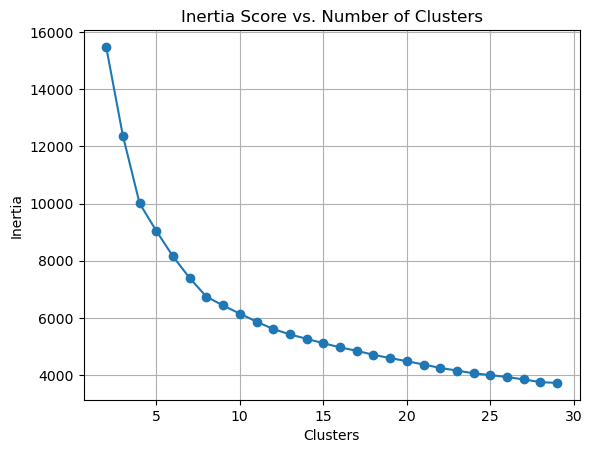

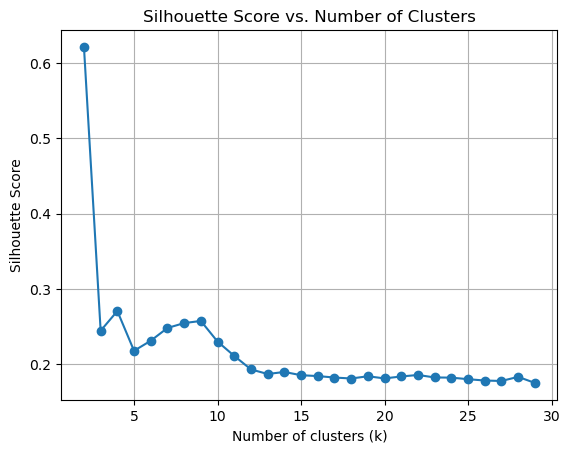

In [16]:
# Plot inertia score
plt.plot(n_clusters, inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title("Inertia Score vs. Number of Clusters")
plt.grid(True)
plt.show()
    
# Plot silhouette score
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

Interpretation:
- From the Inertia score plot, there is no noticable 'elbow', and so we cannot draw any conlusion on the appropriate number of clusters.
- From the Silhouette score plot, the highest Sihouette score is observed when the number of cluster is 2, which suggests that 2 is the ideal number of clusters.

In [18]:
# Perform clustering with 2 centroids
n_clusters = 2
kmeans_model = KMeans(n_clusters=n_clusters)
kmeans_groups = kmeans_model.fit_predict(X_kmeans)

print(pd.Series(kmeans_groups).value_counts())

0    3474
1      89
dtype: int64


Using the suggested number of clusters of 2, the resutling cluster sizes are extremely imabalanced. Therefore, we will try the number of centroids of 4, as it is when the Silhouette Score is the second highest.

In [20]:
# Perform clustering with 4 centroids
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters)
kmeans_groups = kmeans_model.fit_predict(X_kmeans)

print(pd.Series(kmeans_groups).value_counts())

1    1523
0    1200
2     757
3      83
dtype: int64


It appears to be have a more balanced cluster size. Moreover, with the number of cluster of 4, the resulting cluster are interpretable, i.e. there is clear distinction of characteristics between clusters (we will justify the characteristics of each of the 4 clusters later).

### Hierarchical Clustering
- There are several ways of computing distance between clusters:
    - Minimum / Single
    - Average
    - Maximum / Complete
    - Centroid

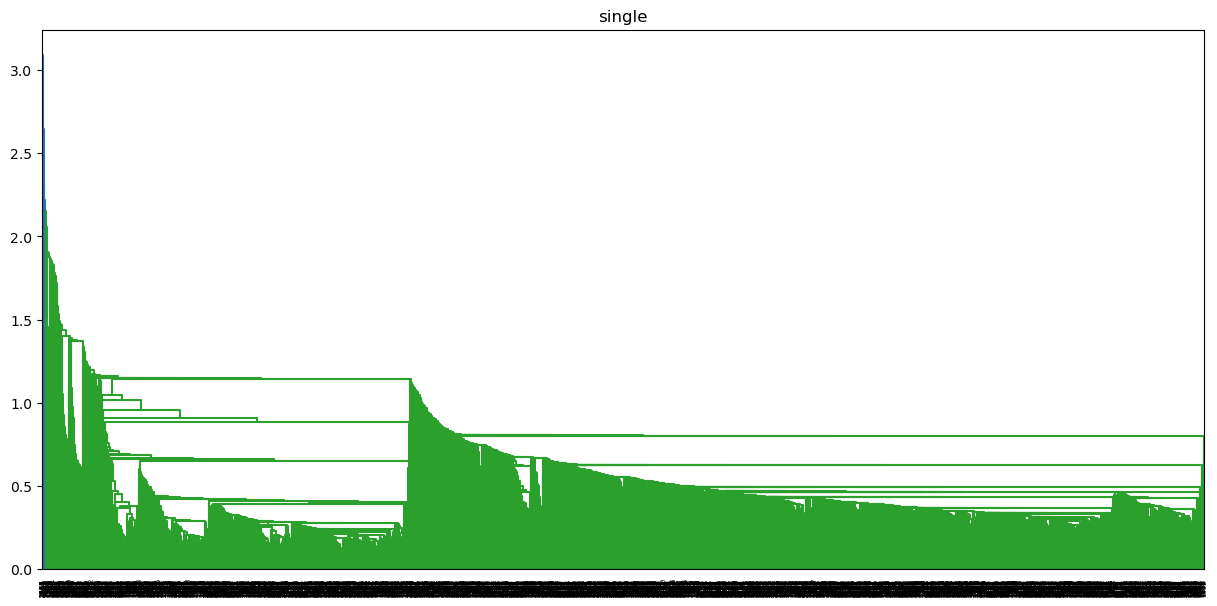

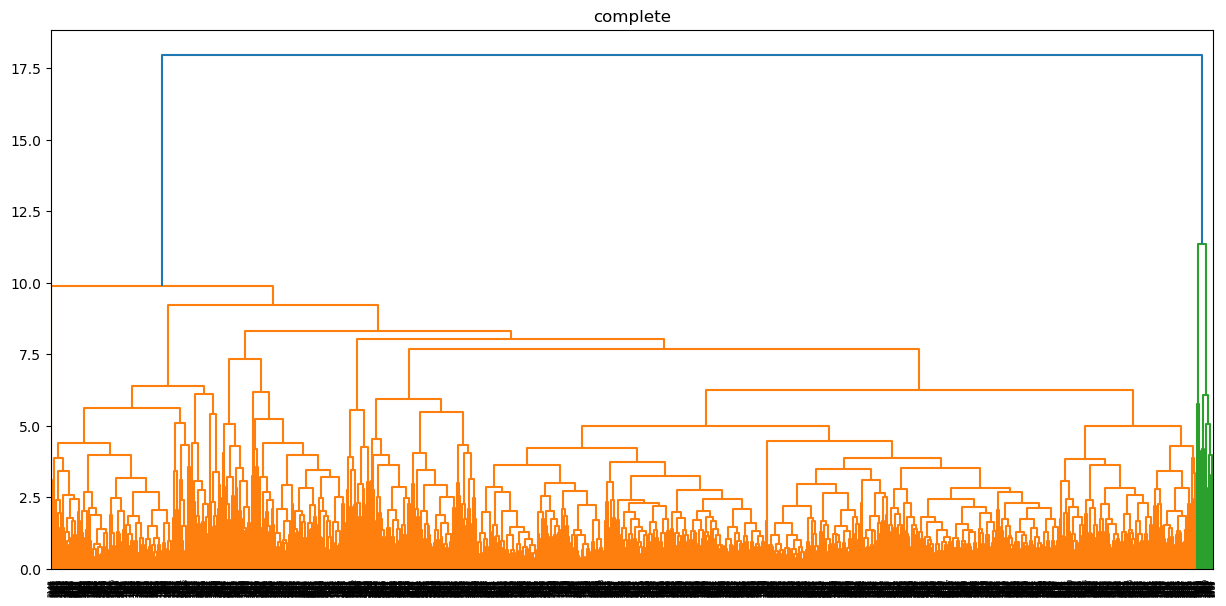

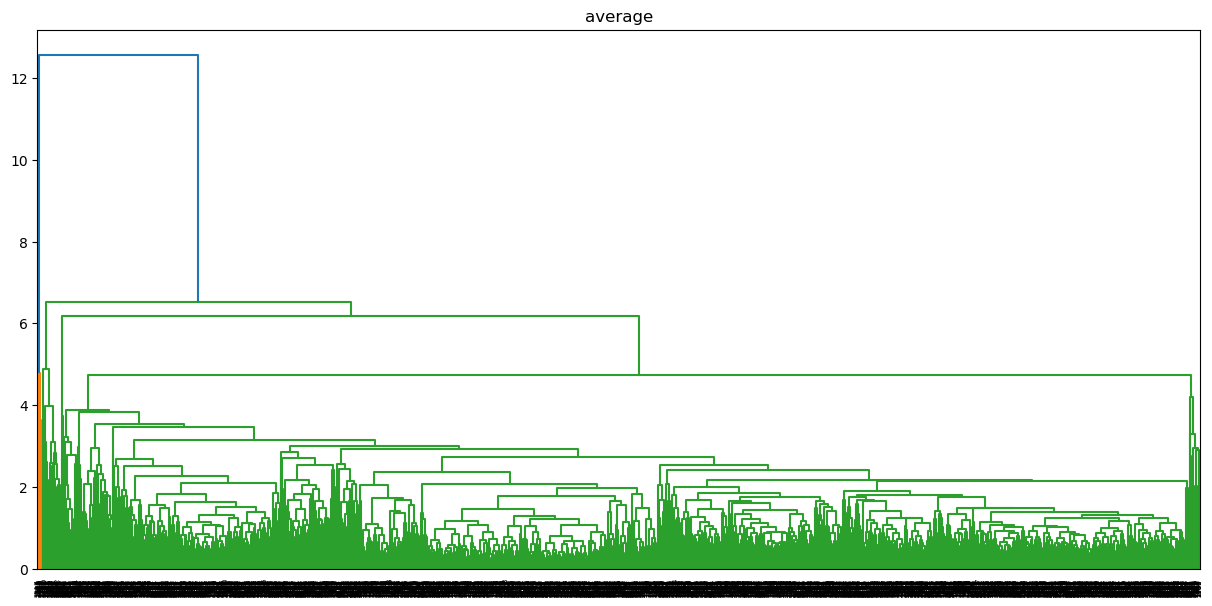

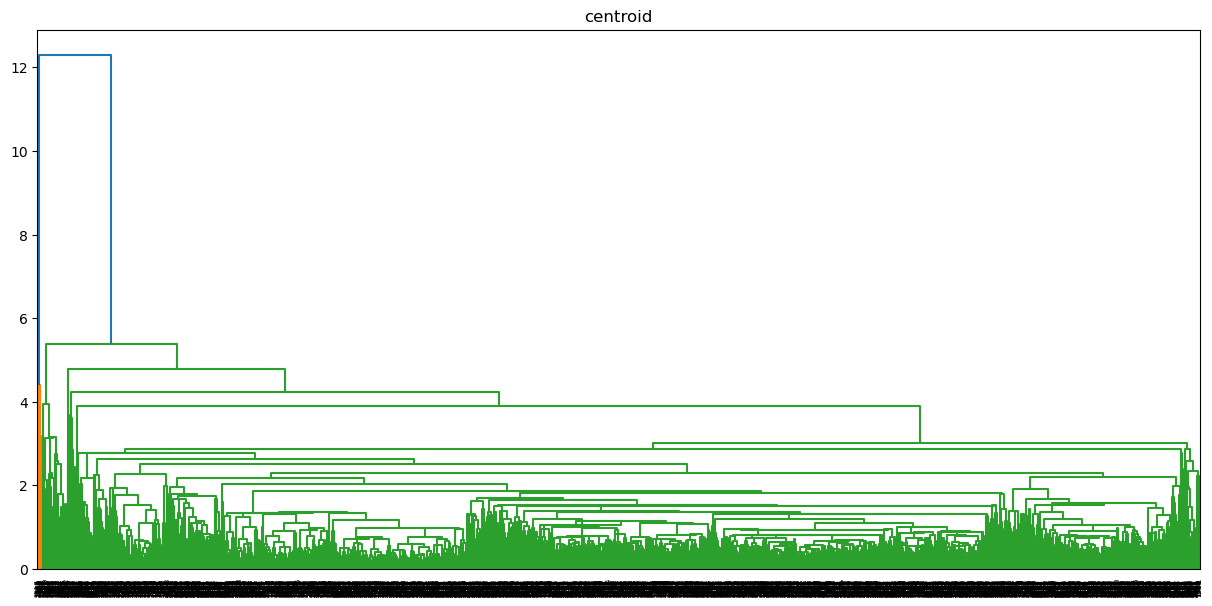

In [23]:
# Generate dendrograms for each distance metric
for dist_type in ['single', 'complete', 'average', 'centroid']:
    model = linkage(X_kmeans, dist_type)
    plt.figure(figsize=(15,7))
    dendrogram(model)
    plt.title(f'{dist_type}')
    plt.show()

While it is unclear on the approriate number of clusters for when the `single` distance metric is used, for all of the other distance metrics, it appears that 2 is the most approriate number of clusters.

In [199]:
hier_labels = {'single':[], 'complete':[], 'average':[], 'centroid':[]}

for dist_type in ['single', 'complete', 'average', 'centroid']:
    # Compute the linkage matrix
    hier_model = linkage(X_kmeans, method=dist_type)

    # Get cluster labels for each data point
    k = 2 # Choose number of clusters
    labels = fcluster(hier_model, k, criterion='maxclust')
    hier_labels[dist_type] = labels

In [196]:
for dist_type in ['single', 'complete', 'average', 'centroid']:
    print(dist_type, ':')
    print(pd.Series(hier_labels[dist_type]).value_counts())

single :
2    3556
1       3
5       1
4       1
6       1
3       1
dtype: int64
complete :
4    2605
2     521
3     382
6      38
5      12
1       5
dtype: int64
average :
6    3483
4      56
2      12
5       5
3       4
1       3
dtype: int64
centroid :
6    3442
3      77
5      20
2      12
4       9
1       3
dtype: int64


Using the suggested number of clusters of 2 (as provided by the dendogram), the resutling cluster sizes are extremely imabalanced. This is a red flag that hierarchical clustering is not capturing meaningful structure in the data, especially when compared to with the earlier KMeans silhouette analysis.

Given that the number of clusters of 2 is based on the longest uniterupted veritcal line from the dendogram, I have also tried to find the second longest uninterupted vertical line which arrives at the number of clusters of 4. When 4 number of clsuters is used, I observed a similar observation as when the number of clusters of 2, i.e. imbalanced cluster sizes.

FINAL SELECTION:
- All in all, we have decided to go with the number of clusters of 4, based on the Silhouette Score analysis of KMeans clustering.

In [78]:
# Perform clustering with 4 centroids
n_clusters = 4
kmeans_model = KMeans(n_clusters=n_clusters)
kmeans_groups = kmeans_model.fit_predict(X_kmeans)

In [80]:
# Assign the appropriate categorization for each of the 4 clusters
cluster_analysis = df[kmeans_features]
cluster_analysis['LABEL'] = kmeans_groups

print(cluster_analysis['LABEL'].value_counts(), '\n')

for i in range(n_clusters):
    selected = cluster_analysis.loc[cluster_analysis['LABEL']==i, :]
    print('Group Label:', i)
    print(selected.mean().round(2))
    print('------------------------------------', '\n')

1    1523
3    1200
0     757
2      83
Name: LABEL, dtype: int64 

Group Label: 0
REVENUE             337377.27
REVENUEGROWTH            8.32
NETPROFITMARGIN         -1.26
GROSSMARGIN              0.36
ASSET               469962.29
CURRENTEMPLOYEES         5.71
COMPANYAGE             894.29
LABEL                    0.00
dtype: float64
------------------------------------ 

Group Label: 1
REVENUE             1786738.18
REVENUEGROWTH             0.41
NETPROFITMARGIN          -1.32
GROSSMARGIN               0.45
ASSET               1705542.56
CURRENTEMPLOYEES         13.48
COMPANYAGE             2339.18
LABEL                     1.00
dtype: float64
------------------------------------ 

Group Label: 2
REVENUE             122092.68
REVENUEGROWTH            4.44
NETPROFITMARGIN         -5.05
GROSSMARGIN             -3.71
ASSET               447808.46
CURRENTEMPLOYEES         6.02
COMPANYAGE            1631.10
LABEL                    2.00
dtype: float64
------------------------------------

- Group 1 (b): Established
    - This group consists of large-sized companies that have secured a well-established position in the market, as reflected by their high total assets, large employee base, and substantial revenue generation. These companies have also achieved operational efficiency, evidenced by their positive gross profit margins, indicating that their core products or services are economically viable. However, despite this operational strength, they are generally loss-making, as reflected in their negative net profit margins.

- Group 2 (c): Scaling with Operational Strain
    - This group consists of moderately sized companies that are focusing on expanding their market share, as reflected by the strong revenue growth. However, to fuel this growth, they likely engage in significant reinvestment, such as aggressive marketing or customer acquisition spending. Moreover, the negative gross margin suggests that their cost of producing or delivering goods/services currently exceeds their revenue, which points to either operational inefficiencies or early-stage pricing strategies. These two factors explain the large negative profit margin observed in this cluster.

- Group 0 (a): Scaling with Efficiency
    - This group consists of mid-sized companies that are focusing on expanding their market share, as reflected by the strong revenue growth. Similar to Group 2, they likely incur significant reinvestment to support this expansion. However, their net profit margin is not as negative as in Group 2 because entities in this group have a positive gross margin, indicating that their core operations are economically viable. Moreover, they exhibit higher revenue growth than Group 2.

- Group 3 (d): Early-Stage
    - It represents very early ventures with a good majority of entities in the cluster are at pre-revenue level. Companies at this stage incur a lot of expenses related to R&D, in which when combined with low or no revenue stream, these companies suffer from large losses.

In [84]:
# Rename the cluster name
cluster_analysis['LABEL'] = cluster_analysis['LABEL'].map({0:'a',1:'b',2:'c',3:'d'})

# Perform one-hot-encoding on the cluster label
cluster_analysis = pd.get_dummies(cluster_analysis, columns=['LABEL'])

In [88]:
# Add the feature to the dataset
additional = cluster_analysis[['LABEL_a','LABEL_b', 'LABEL_c','LABEL_d']]

X_all      = pd.concat([X_all,      additional], axis=1)
X_basic    = pd.concat([X_basic,    additional], axis=1)

In [183]:
# Rename the columns
X_export = X_all.rename(columns={
    'LABEL_a': 'IS_EARLY',
    'LABEL_b': 'IS_ESTABLISHED',
    'LABEL_c': 'IS_SCALINGSTRAIN',
    'LABEL_d': 'IS_SCALINGEFFICIENT'
}
                       )

In [187]:
# Export the new dataset
X_export.to_csv('ml_features_cluster.csv')

-----------------------------------------